<a href="https://colab.research.google.com/github/alvinrach/24-NLP-LSTM-News-Title-Classification/blob/main/NLP_LSTM_News_Title_Classification_Alvin_Rachmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alvin Rachmat**

**NLP-LSTM : News Title Classification**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

!pip install contractions
import re
import contractions
import nltk
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
url = 'https://drive.google.com/file/d/1GRg1E-3eYkTwMkaFEy4khaTSeoboSOw5/view?usp=sharing'
dwn_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
d = pd.read_excel(dwn_url)
len(d)

65535

Just use some of the data, since there is a bug of LSTM which in a certain amount point of data, will result error (in my plain jupyter) or will result in extremely significant raise of train time (colab)
https://github.com/tensorflow/tensorflow/issues/33721

In [15]:
d=d.iloc[:52000,:]
d = d.drop('No', axis=1)
d

,News Title,Category
0,Google+ rolls out 'Stories' for tricked out ph...,Technology
1,Dov Charney's Redeeming Quality,Business
2,White God adds Un Certain Regard to the Palm Dog,Entertainment
3,"Google shows off Androids for wearables, cars,...",Technology
4,China May new bank loans at 870.8 bln yuan,Business
...,...,...
51995,MH370: poor conditions hamper search for debri...,Business
51996,"Tech stocks, Nasdaq take a tumble",Business
51997,Climate Action Plan - Strategy to Cut Methane ...,Business
51998,Breakthrough: Living materials created by MIT ...,Technology


In [16]:
# Cleaning the texts
def txtprocess(txt):
    # Lower the texts
    txt = str(txt).lower()
    # Remove contractions
    txt = contractions.fix(txt)

    # Just pick the alphabet
    txt = re.sub(r'[^a-zA-Z]', ' ', txt)
    # Fix unnecessary space
    txt = re.sub(' +', ' ', txt)

    txt = ' '.join(txt.split())

    return txt

d['News Title'] = d['News Title'].apply(txtprocess)

In [17]:
# Cleaning stopwords. Omit the negative maker words (I found this quite effective on this case)
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

def remove_stopwords(txt):
    no_stopword_txt = [w for w in txt.split() if not w in stop_words]
    return ' '.join(no_stopword_txt)

d['News Title'] = d['News Title'].apply(lambda x: remove_stopwords(x))

In [18]:
# Create new table consists of dummified label
category = pd.get_dummies(d.Category)
d_new = pd.concat([d, category], axis=1)
d_new = d_new.drop('Category',axis=1)
d_new

,News Title,Business,Entertainment,Medical,Technology
0,google rolls stories tricked photo playback,False,False,False,True
1,dov charney redeeming quality,True,False,False,False
2,white god adds un certain regard palm dog,False,True,False,False
3,google shows androids wearables cars tvs,False,False,False,True
4,china may new bank loans bln yuan,True,False,False,False
...,...,...,...,...,...
51995,mh poor conditions hamper search debris indian...,True,False,False,False
51996,tech stocks nasdaq take tumble,True,False,False,False
51997,climate action plan strategy cut methane emiss...,True,False,False,False
51998,breakthrough living materials created mit scie...,False,False,False,True


In [19]:
# Get data as array
title = d_new['News Title'].values
label = d_new[category.columns].values
title_train, title_test, y_train, y_test = train_test_split(title, label, test_size=0.2, random_state=42)

In [20]:
# Mark the uncategorized words as -
# Don't let the test data be fitted also (dont let test data know the train data)
tokenizer = Tokenizer(num_words=None, oov_token='-')
tokenizer.fit_on_texts(title_train)

sekuens_train = tokenizer.texts_to_sequences(title_train)
sekuens_test = tokenizer.texts_to_sequences(title_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [21]:
# As reminder to the shape of the padded_train
sekuens_train[:5], padded_train

([[2220, 1073, 10718, 216, 4121, 110],
  [512, 1660, 439, 1571, 6372, 7911, 6373],
  [15, 371, 26, 2079, 500],
  [1491, 13, 36, 5022, 1760, 3917, 145],
  [22, 21, 67, 34, 540, 501, 10719, 716, 2338, 2589]],
 array([[   0,    0,    0, ...,  216, 4121,  110],
        [   0,    0,    0, ..., 6372, 7911, 6373],
        [   0,    0,    0, ...,   26, 2079,  500],
        ...,
        [   0,    0,    0, ...,  107,  111,  222],
        [   0,    0,    0, ..., 1292, 7118,  410],
        [   0,    0,    0, ..., 1061,  882,   14]], dtype=int32))

In [25]:
# Length of each tokenized data
# The size of input nodes, or input length in embedding layer (if use flatten after that) (use train)
len(padded_train[1]), len(padded_test[1])

(101, 13)

In [26]:
## Length of the data
len(padded_train), len(padded_test)

(41600, 10400)

In [27]:
# Check word index of the tokenized data
print(dict(list(tokenizer.word_index.items())[:30]))

{'-': 1, 'new': 2, 'us': 3, 'not': 4, 'google': 5, 'apple': 6, 'video': 7, 'says': 8, 'first': 9, 'samsung': 10, 'may': 11, 'one': 12, 'facebook': 13, 'report': 14, 'microsoft': 15, 'star': 16, 'watch': 17, 'galaxy': 18, 'china': 19, 'day': 20, 'kardashian': 21, 'kim': 22, 'season': 23, 'review': 24, 'but': 25, 'deal': 26, 'million': 27, 'game': 28, 'amazon': 29, 'world': 30}


In [28]:
# Richness of the words
len(tokenizer.word_index)

21943

https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

In [29]:
# to decide LSTM hidden nodes
hidden_nodes = int(2/3 * (len(padded_train[1]) * len(category.columns)))
hidden_nodes

269

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542

In [31]:
# another way to decide LSTM hidden nodes
# alpha 5-10, some say its 2-10
alpha = 10
hidden_nodes = int(len(padded_train)/(alpha*(len(padded_train[1]) * len(category.columns))))
hidden_nodes

10

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

https://forums.fast.ai/t/embedding-layer-size-rule/50691/13

In [32]:
# Let the indicator that has been scrutinized kept as markdown
# Note for myself: Next time, document all the tries with a train-val-loss-accuracy plot, each trial attach the model code
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=500),#(input_dim=len(tokenizer.word_index)+2, output_dim=500),
    tf.keras.layers.LSTM(hidden_nodes, dropout=0.96),#, kernel_regularizer=tf.keras.regularizers.l2(0.01)),#, recurrent_dropout=0.3),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(56, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Let the indicator that has been scrutinized kept as markdown
# Note for myself: Next time, document all the tries with a train-val-loss-accuracy plot, each trial attach the model code
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=500),
    tf.keras.layers.LSTM(hidden_nodes, dropout=0.96),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
set_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(padded_train, y_train, epochs=60, batch_size=128,
                    validation_data=(padded_test, y_test), callbacks=[set_callback], verbose=2)

Epoch 1/60
325/325 - 13s - 40ms/step - accuracy: 0.5475 - loss: 1.0653 - val_accuracy: 0.7309 - val_loss: 0.7045
Epoch 2/60
325/325 - 15s - 46ms/step - accuracy: 0.7914 - loss: 0.5668 - val_accuracy: 0.8198 - val_loss: 0.5077
Epoch 3/60
325/325 - 5s - 14ms/step - accuracy: 0.8541 - loss: 0.4206 - val_accuracy: 0.8536 - val_loss: 0.4223
Epoch 4/60
325/325 - 5s - 17ms/step - accuracy: 0.8776 - loss: 0.3548 - val_accuracy: 0.8638 - val_loss: 0.3870
Epoch 5/60
325/325 - 5s - 15ms/step - accuracy: 0.8910 - loss: 0.3160 - val_accuracy: 0.8721 - val_loss: 0.3703
Epoch 6/60
325/325 - 5s - 15ms/step - accuracy: 0.9031 - loss: 0.2828 - val_accuracy: 0.8779 - val_loss: 0.3505
Epoch 7/60
325/325 - 5s - 16ms/step - accuracy: 0.9098 - loss: 0.2653 - val_accuracy: 0.8803 - val_loss: 0.3445
Epoch 8/60
325/325 - 5s - 14ms/step - accuracy: 0.9166 - loss: 0.2478 - val_accuracy: 0.8913 - val_loss: 0.3273
Epoch 9/60
325/325 - 5s - 14ms/step - accuracy: 0.9206 - loss: 0.2343 - val_accuracy: 0.8887 - val_los

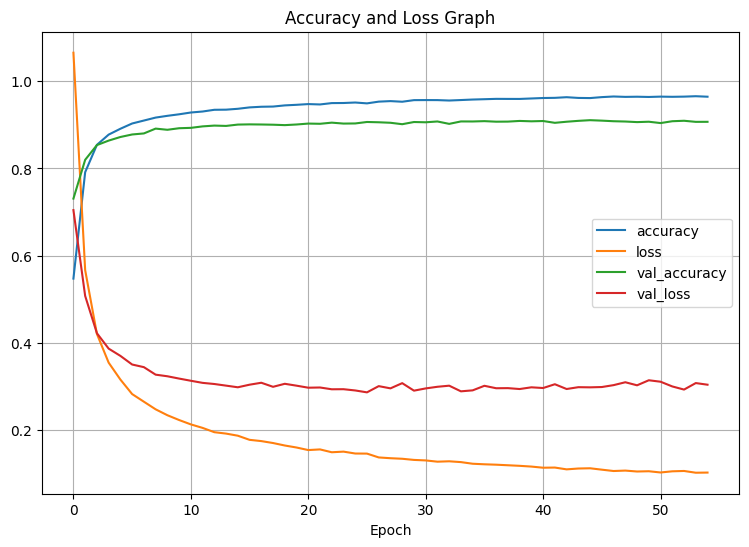

In [34]:
# Plotting loss and accuracy, train and validation, each epoch
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid()

In [46]:
model.predict(padded_test[0].reshape(1,len(padded_test[0])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


array([[2.4133088e-04, 9.9952650e-01, 1.0081673e-04, 1.3144391e-04]],
      dtype=float32)

In [47]:
padded_test[0].reshape(1,len(padded_test[0]))

array([[    0,     0,     0,     1,     1,     1,     1,  4389,  2206,
        16135,  2570,  4928, 12775]], dtype=int32)

In [49]:
title_test[0]

'kors blimey freida pinto stuns nude feathered designer gown saint'

In [50]:
y_test[0]

array([False,  True, False, False])

Which is true that the second is True and highest at probability